In [556]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import json

In [557]:
with open("../data/output/labeled_sample_adam.jsonl", "r") as file:
    adas = [json.loads(line) for line in file]

with open("../data/output/labeled_sample_jan.jsonl", "r") as file:
    janeczek = [json.loads(line) for line in file]

In [558]:
mapping = {
    "Mowa nienawiści": "Hate",
    "Neutralny": "Neutral",
    "Wzmacnianie": "Strenghtening",
    "Osłabianie": "Weakening",
    "Neutral": "Neutral",
    "Hate": "Hate",
    "Strenghtening": "Strenghtening",
    "Weakening": "Weakening",
    "Odwracanie": "Reversing",
}

In [559]:
def fix_labels_adam(data):
    for anno in data:
        merged_labels = []
        anno['label'].sort(key=lambda x: x[0]) 
        
        for label in anno['label']:
            if not merged_labels:
                merged_labels.append(label)
            else:
                last_label = merged_labels[-1]
                if last_label[2] == label[2]:
                    last_label[1] = max(last_label[1], label[1])
                else:
                    merged_labels.append(label)

        anno['label'] = merged_labels
        for label in anno['label']:
            label[2] = mapping[label[2]]

    return data

In [560]:
adas = fix_labels_adam(adas)

In [561]:
adam_labels = [annotation["label"][0][2] for annotation in adas]
janek_labels = [annotation["entities"][0]["label"] for annotation in janeczek]

In [562]:
results = {
    ("Neutral", "Neutral"): 0,
    ("Hate", "Neutral"): 0,
    ("Neutral", "Hate"): 0,
    ("Hate", "Hate"): 0,
}

for adam, janek in zip(adam_labels, janek_labels):
    results[(adam, janek)] += 1

In [563]:
results

{('Neutral', 'Neutral'): 89,
 ('Hate', 'Neutral'): 4,
 ('Neutral', 'Hate'): 1,
 ('Hate', 'Hate'): 6}

/tmp/ipykernel_40774/749807516.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  cm_plot.axes.set_xticklabels(["", "Hate", "Neutral"], rotation=45)
/tmp/ipykernel_40774/749807516.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  cm_plot.axes.set_yticklabels(["", "Hate", "Neutral"], rotation=45)


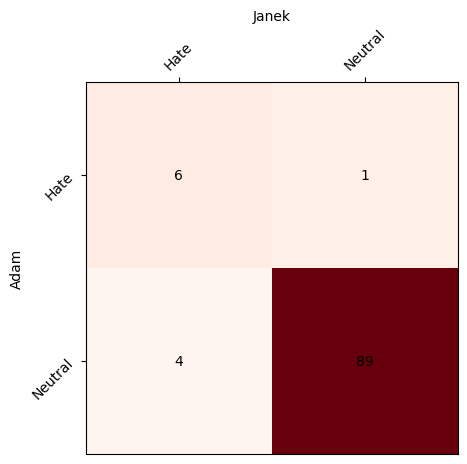

In [564]:
cm = confusion_matrix(adam_labels, janek_labels)
cm_plot = plt.matshow(cm, cmap=plt.cm.Reds)
cm_plot.axes.set_xticklabels(["", "Hate", "Neutral"], rotation=45)
cm_plot.axes.set_yticklabels(["", "Hate", "Neutral"], rotation=45)
cm_plot.axes.set_xlabel("Janek")
cm_plot.axes.set_ylabel("Adam")
cm_plot.axes.grid(False)
cm_plot.axes.xaxis.set_ticks_position('top')
cm_plot.axes.xaxis.set_label_position('top')
cm_plot.axes.text(0, 0, results["Hate", "Hate"], color="black", ha="center", va="center")
cm_plot.axes.text(1, 0, results["Neutral", "Hate"], color="black", ha="center", va="center")
cm_plot.axes.text(0, 1, results["Hate", "Neutral"], color="black", ha="center", va="center")
cm_plot.axes.text(1, 1, results["Neutral", "Neutral"], color="black", ha="center", va="center")
plt.show()

In [565]:
ppa_sentences = round((2*89/(2*89+4+1))*100, 2)
ppa_sentences

97.27

In [566]:
def filter_hate_neutral_adas(data):
    for annotation in data:
        annotations_without_hate_neutral = []
        for label in annotation["label"]:
            if label[2] != "Hate" and label[2] != "Neutral":
                annotations_without_hate_neutral.append(label)
        annotation["label"] = annotations_without_hate_neutral
    
    return data

In [567]:
def filter_hate_neutral_janek(data):
    for annotation in data:
        annotations_without_hate_neutral = []
        for entity in annotation["entities"]:
            if entity["label"] != "Hate" and entity["label"] != "Neutral":
                annotations_without_hate_neutral.append(entity)
        annotation["entities"] = annotations_without_hate_neutral
    return data

In [568]:
def ranges_match(ann1, ann2):
    match = (abs(ann1['start_offset'] - ann2[0]) <= 2 and 
            abs(ann1['end_offset'] - ann2[1]) <= 2 and 
            ann1['label'].lower() == ann2[2].lower())
    return match

In [569]:
filtered_adas = filter_hate_neutral_adas(adas)

In [570]:
filtered_labels_adam = [annotation["label"] for annotation in filtered_adas]

In [571]:
filtered_janek = filter_hate_neutral_janek(janeczek)

In [572]:
filtered_labels_janek = [annotation["entities"] for annotation in filtered_janek]

In [573]:
both_labeled = 0
first_labeled_second_not = 0
second_labeled_first_not = 0

for data1, data2 in zip(filtered_janek, filtered_adas):
    matched_1 = [False] * len(data1['entities'])
    matched_2 = [False] * len(data2['label'])

    for i, ent1 in enumerate(data1['entities']):
        for j, lab2 in enumerate(data2['label']):
            pair_labels = (ent1['label'], lab2[2])
            if ranges_match(ent1, lab2):
                both_labeled += 1
                matched_1[i] = True
                matched_2[j] = True
            else:
                if not matched_1[i]:
                    first_labeled_second_not += 1
                if not matched_2[j]:
                    second_labeled_first_not += 1

print(f"Both agreed: {both_labeled}")
print(f"Janek labelled, Adam did not: {first_labeled_second_not}")
print(f"Adam labelled, Janek did not: {second_labeled_first_not}")

Both agreed: 6
Janek labelled, Adam did not: 3
Adam labelled, Janek did not: 2


In [576]:
ppa_phrases = round((2*both_labeled/(2*both_labeled+first_labeled_second_not+second_labeled_first_not))*100, 2)
ppa_phrases

70.59

In [577]:
ppa_mean = round((ppa_sentences + ppa_phrases) / 2, 2)
ppa_mean

83.93